[20900] Error: "Column(s) ['negative reviews', 'positive reviews'] do not exist"
Model Evaluation:
R² Score: 0.0259
Mean Absolute Error: 133.67


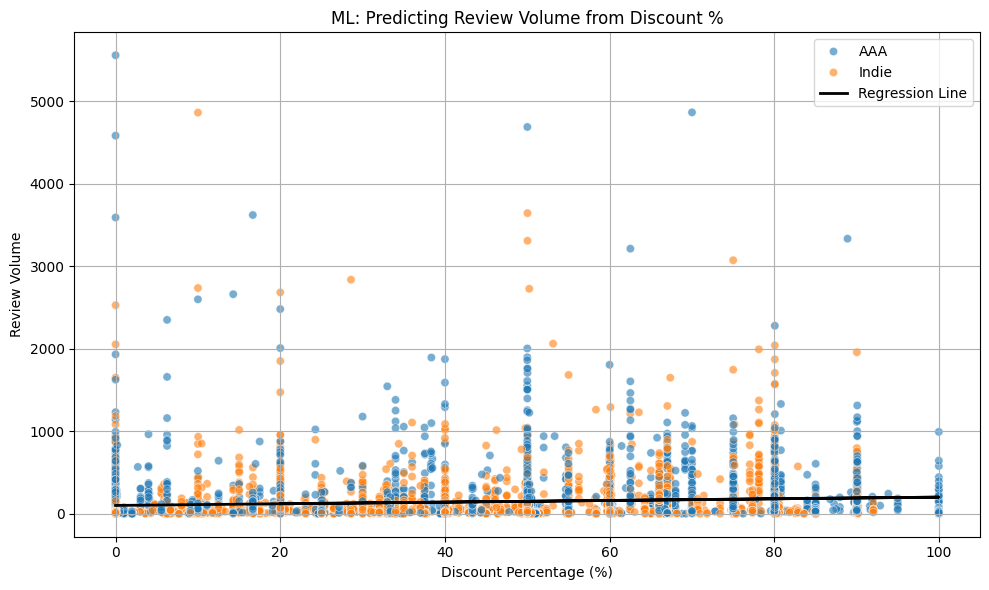

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

with open("100_Steam_Assortment.json", "r", encoding="utf-8") as f:
    games = json.load(f)

appid_type_map = {str(game["appid"]): game["type"] for game in games}

review_folder = "ReviewHistory"
price_folder = "PriceHistory"

records = []

for appid in appid_type_map:
    review_path = os.path.join(review_folder, f"{appid}.csv")
    price_path = os.path.join(price_folder, f"{appid}.csv")

    if not os.path.exists(review_path) or not os.path.exists(price_path):
        continue

    try:
        review_df = pd.read_csv(review_path)
        price_df = pd.read_csv(price_path)

        review_df.columns = [col.strip().lower() for col in review_df.columns]
        price_df.columns = [col.strip().lower() for col in price_df.columns]

        if "final price" not in price_df.columns or "historical low" not in price_df.columns:
            continue

        review_df["date"] = pd.to_datetime(review_df["datetime"]).dt.date
        price_df["date"] = pd.to_datetime(price_df["datetime"]).dt.date

        review_grouped = review_df.groupby("date").agg({
            "positive reviews": "sum",
            "negative reviews": "sum"
        }).reset_index()

        price_grouped = price_df.groupby("date").agg({
            "final price": "last",
            "historical low": "last"
        }).reset_index()

        merged = pd.merge(review_grouped, price_grouped, on="date", how="inner")
        merged["discount_percent"] = 100 * (merged["final price"] - merged["historical low"]) / merged["final price"]
        merged["discount_percent"] = merged["discount_percent"].clip(lower=0)
        merged["review_volume"] = merged["positive reviews"] + merged["negative reviews"]
        merged = merged.dropna(subset=["discount_percent", "review_volume"])
        merged = merged[merged["review_volume"] > 0]

        for _, row in merged.iterrows():
            records.append({
                "appid": appid,
                "discount_percent": row["discount_percent"],
                "review_volume": row["review_volume"],
                "type": appid_type_map[appid]
            })

    except Exception as e:
        print(f"[{appid}] Error: {e}")
        continue

df = pd.DataFrame(records)

if df.empty:
    print("No data available.")
else:
    X = df[["discount_percent"]]
    y = df["review_volume"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Model Evaluation:")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="discount_percent", y="review_volume", data=df, hue="type", alpha=0.6)
    plt.plot(X_test, y_pred, color='black', linewidth=2, label="Regression Line")
    plt.title("ML: Predicting Review Volume from Discount %")
    plt.xlabel("Discount Percentage (%)")
    plt.ylabel("Review Volume")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\micke\AppData\Local\Temp\ipykernel_39720\3893026937.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=discount_df, x="Type", y="Discount Ratio", inner="box", palette="Set2")


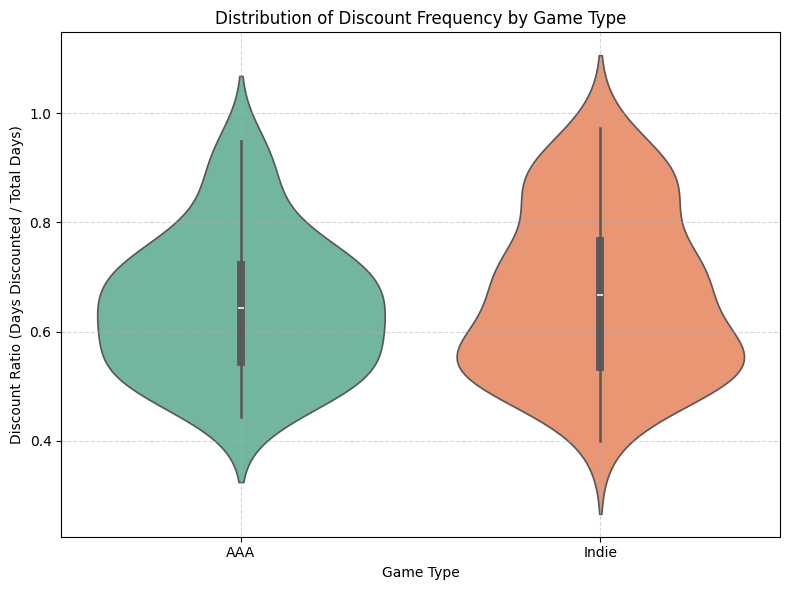

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

with open("100_Steam_Assortment.json", "r", encoding="utf-8") as f:
    games = json.load(f)

appid_type_map = {str(game["appid"]): game["type"] for game in games}

price_folder = "PriceHistory"
discount_freq = {"AAA": [], "Indie": []}

for appid, gtype in appid_type_map.items():
    path = os.path.join(price_folder, f"{appid}.csv")
    if not os.path.exists(path):
        continue

    try:
        df_discount_reviews = pd.read_csv(path)
        df_discount_reviews.columns = [col.strip().lower() for col in df_discount_reviews.columns]
        if "final price" not in df_discount_reviews.columns or "historical low" not in df_discount_reviews.columns:
            continue

        df_discount_reviews["final price"] = pd.to_numeric(df_discount_reviews["final price"], errors="coerce")
        df_discount_reviews["historical low"] = pd.to_numeric(df_discount_reviews["historical low"], errors="coerce")

        df_discount_reviews["is_discounted"] = df_discount_reviews["historical low"] < df_discount_reviews["final price"]
        num_discount_days = df_discount_reviews["is_discounted"].sum()
        total_days = len(df_discount_reviews)

        if total_days > 0:
            discount_ratio = num_discount_days / total_days
            discount_freq[gtype].append(discount_ratio)
    except Exception as e:
        print(f"Error processing AppID {appid}: {e}")

discount_df = pd.DataFrame([
    {"Type": "AAA", "Discount Ratio": ratio} for ratio in discount_freq["AAA"]
] + [
    {"Type": "Indie", "Discount Ratio": ratio} for ratio in discount_freq["Indie"]
])

plt.figure(figsize=(8, 6))
sns.violinplot(data=discount_df, x="Type", y="Discount Ratio", inner="box", palette="Set2")
plt.title("Distribution of Discount Frequency by Game Type")
plt.ylabel("Discount Ratio (Days Discounted / Total Days)")
plt.xlabel("Game Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


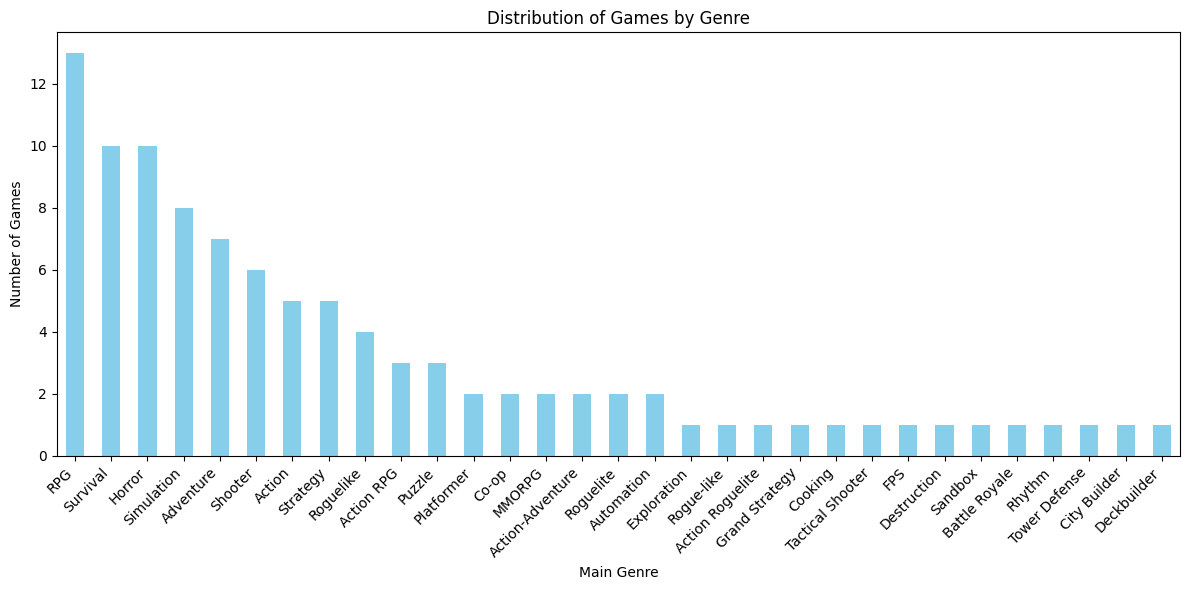

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import json

with open("100_Steam_Assortment.json", "r", encoding="utf-8") as f:
    games = json.load(f)

game_names = [game["name"] for game in games if game["name"]]

text = " ".join(game_names)

genres = []
for game in games:
    genre = game.get("genre", "")
    if genre:
        main_genre = genre.split(',')[0].strip()
        genres.append(main_genre)

genre_counts = pd.Series(genres).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Main Genre")
plt.ylabel("Number of Games")
plt.title("Distribution of Games by Genre")
plt.tight_layout()
plt.show()
